In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md

# for date and month formats in french or german
import locale

# set the locale to the language desired
# the locale is set back to to original at the the end of the script
# loc = locale.getlocale()
lang =  'de_DE.utf8'
# locale.setlocale(locale.LC_ALL, lang)

# the date is in iso standard:
date_format = "%Y-%m-%d"

# it gets changed to german format
german_date_format = "%d.%m.%Y"

# set some parameters:
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100m"

# charting and colors
sns.set_style("whitegrid")
table_row = "saddlebrown"
# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

## !! Begin Note book variables !!

# Changing these variables produces different reports
# Call the map image
bassin_map = "resources/maps/survey_areas/aare_scaled.jpeg"

# top level aggregation
top = "Alle Erhebungsgebiete"
top_name = ["Alle Erhebungsgebiete"]

# define the feature level and components
this_feature = {'slug':'aare', 'name':"Erhebungsgebiet Aare", 'level':'river_bassin'}
this_level = 'water_name_slug'
this_bassin = "aare"
bassin_label = "Erhebungsgebiet Aare"

lakes_of_interest = ["neuenburgersee", "thunersee", "bielersee", "brienzersee"]
# !! End note book variables !!

# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# Object code definitions, labels and material type
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)
# set the index of code data to code
dfCodes.set_index("code", inplace=True)
# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# language specific
# importing german code descriptions
de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
de_codes.set_index("code", inplace=True)

for x in dfCodes.index:
    dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]
    
# translate the material column
dfCodes["material"] = dfCodes.material.map(lambda x: sut.mat_ge[x]) 

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

In [2]:
class SectionTitle:   
    def __init__(self, doctitle="", dochref="", language_tag="", **kwargs):
        self.doctitle = doctitle
        self.dochref=dochref
        self.language_tag=language_tag
    
    def sectionTitle(self, **kwargs):
        titleString = f'{self.dochref} \n{self.doctitle}'
        return titleString
    
    def languageRef(self, **kwargs):
        return f'\n{self.language_tag}'
    
    def titleLanguage(self, **kwargs):
        section_block = f'{self.sectionTitle()}{self.languageRef()}'
        return section_block
    
    def __str__(self):
        return (self.doctitle, self.dochref, self.language_tag)
    
    
kwargs = dict(doctitle='# Aare',  dochref='(aaresa)=',  language_tag='<a href="aare_sa_de.html"> Deutsch </a>')
TitleBlock = SectionTitle(**kwargs)

md(TitleBlock.titleLanguage())

(aaresa)= 
# Aare
<a href="aare_sa_de.html"> Deutsch </a>

In [3]:
class Caption:
    
    position=''
    figure_number=0
    captions=[]
    start_caption = ""
    end_caption = '*'
    
    def buildCaption(self):
        start_caption = f'*__{self.position}:__'
        new_string=''
        for line in self.captions:
            new_string += line
        end_caption = self.end_caption
        
        return f'{start_caption} {new_string}{end_caption}'
            
# *__Below:__ Map of survey locations March 2020 - May 2021. Marker diameter = the mean survey result in pieces of litter per 100 meters (p/100m).*   
map_caption = Caption()
map_caption.position = "Unten"
map_caption.captions = [
    "Karte des Erhebungsgebiets März 2020 bis Mai 2021. ",
    "Der Durchmesser der Punktsymbole entspricht dem Median der",
    "Abfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort."
]
md(map_caption.buildCaption())

*__Unten:__ Karte des Erhebungsgebiets März 2020 bis Mai 2021. Der Durchmesser der Punktsymbole entspricht dem Median derAbfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort.*

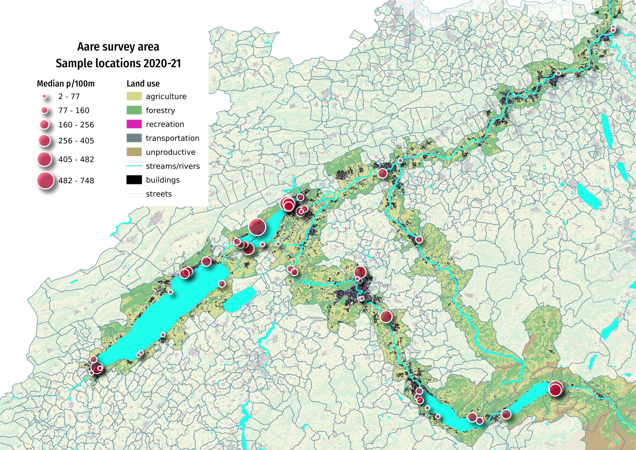

In [4]:
sut.display_image_ipython(bassin_map, thumb=(800,450))

## Erhebungsorte und Landnutzungsprofile

In [5]:
def thereIsData(data=False, atype=(pd.DataFrame, )):
    # checkes that the provided data is a certain type
    if isinstance(data, atype):
        return data
    else:
        raise TypeError(f"There is no data or it is not the right type: is_instance({data}, {atype}).")

def loadData(filename):
    # loads data from a .csv
    filename = thereIsData(data=filename, atype=(str,))
    
    try:
        a = pd.read_csv(filename)        
    except OSError:
        print("The file could not be read, is this the right file extension?")
        raise
    return a

def changeColumnNames(data, columns={}):
    # changes the column names of a data frame
    data = thereIsData(data=data, atype=(pd.DataFrame, ))
    cols = thereIsData(data=columns, atype=(dict, ))
    
    try:
        a = data.rename(columns=columns)
    except ValueError:
        print("The columns did not go with the data")
        raise
    return a

def makeEventIdColumn(data, feature_level, these_features=[], index_name="loc_date", index_prefix="location", index_suffix="date", **kwargs):
    # Combines the location and date column into one str: "slug-date"
    # makes it possible ot group records by event
    # converts string dates to timestamps and localizes to UTC
    data = thereIsData(data=data, atype=(pd.DataFrame, ))
    feature_level = thereIsData(data=feature_level, atype=(str, ))
    these_features = thereIsData(data=these_features, atype=(list, np.ndarray))
    
    try:
        sliced_data = data[data[feature_level].isin(these_features)].copy()    
        sliced_data[index_name] = list(zip(sliced_data[index_prefix].values, sliced_data[index_suffix].values))
        sliced_data["date"] = pd.to_datetime(sliced_data["date"], format=date_format).dt.tz_localize('UTC')
    except RuntimeError:
        print("The pandas implementation did not function")
        raise
    
    return sliced_data
    
def featureData(filename, feature_level, these_features=[], columns=False):
    # makes the feature data to be explored    
    data = loadData(filename)
    
    if columns != False:
        data = changeColumnNames(data, columns=columns)
    a = makeEventIdColumn(data, feature_level, these_features=these_features)
    
    return a, data

def convert_case(str_camelcase):
    # This function takes in a string in camelCase and converts it to snake_case
    str_camelcase = thereIsData(data=str_camelcase, atype=(str, ))
    str_snake_case = ""
    for ele in list(str_camelcase):
        if ele.islower():
            str_snake_case = str_snake_case + ele
        else:
            str_snake_case = str_snake_case + "_" + ele.lower()
    return str_snake_case


def checkInitiateAttribute(data=False, check=False, atype=(list, np.ndarray), a_method=None, **kwargs):
    # check the data type of the requested element against the required data type
    # if check the data is returned, else <a_method> will be applied to <data>
    # and checked again.    
    if isinstance(check, atype):
        return check
    else:
        try:
            new_data = a_method(data)
            check_again = checkInitiateAttribute(check=new_data, data=new_data, atype=atype, a_method=a_method, **kwargs)
            return check_again
            
        except ValueError:
            print("neither the data nor the method worked")
            raise
            
def uniqueValues(data):
    # method to pass pd.series.unique as a variable
    return data.location.unique()

def dateToYearAndMonth(python_date_object, fmat='wide', lang=""):
    a_date = thereIsData(data=python_date_object, atype=(datetime, ))
    amonth = a_date.month
    a_year = a_date.year
    amonth_foreign = get_month_names(fmat, locale=lang)[amonth]
    
    return f'{amonth_foreign} {a_year}'
    

# the survey data
filename = "resources/checked_sdata_eos_2020_21.csv"
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings"}
fd, a_data = featureData(filename, this_feature["level"], these_features=[this_feature["slug"]], columns=columns)


class Beaches:
    """The dimendsional and geo data for each survey location"""
    df_beaches = dfBeaches
    

class AdministrativeSummary(Beaches):
       
    col_nunique_qty=["location", "loc_date", "city"]
    col_sum_qty = ["quantity"]
    col_population = ["city", "population"]
    col_sum_pop = ["population"]
    col_nunique_city = ["city"]
    locations_of_interest = None
    lakes_of_interest = None
    rivers_of_interest = None
    
    def __init__(self, data = None, label=None, **kwargs):
        
        self.data = data
        self.label = label
        super().__init__()    
        
    def locationsOfInterest(self, **kwargs):        
        data = thereIsData(self.data, (pd.DataFrame))
        locations = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues, **kwargs)
                
        self.locations_of_interest = locations
    
    def resultsObject(self, col_nunique=None, col_sum=None, **kwargs):
        data = thereIsData(self.data, (pd.DataFrame))
        
        if not col_nunique:
            col_nunique=self.col_nunique_qty
        if not col_sum:
            col_sum=self.col_sum_qty
            
        t = sut.make_table_values(data, col_nunique=col_nunique, col_sum=col_sum)
        
        return t
    
    def populationKeys(self):
        data = thereIsData(self.data, (pd.DataFrame))
        locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)
        
        try:
            popmap = self.df_beaches.loc[locs][self.col_population].drop_duplicates()
        except TypeError as e:
            print("that did not work")
        
        return popmap
    
    def lakesOfInterest(self):
        data = thereIsData(self.data, (pd.DataFrame))
        locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)
        
               
        if not isinstance(self.lakes_of_interest, list):
            mask = (self.df_beaches.index.isin(locs))&(self.df_beaches.water == "l")
            d = self.df_beaches.loc[mask]["water_name"].unique()
            self.lakes_of_interest = d
            return d
        else:
            return self.lakes_of_interest
        
    def riversOfInterest(self):
        data = thereIsData(self.data, (pd.DataFrame))        
        locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)      
        
        if not isinstance(self.rivers_of_interest, list):
            mask = (self.df_beaches.index.isin(locs))&(self.df_beaches.water == "r")
            d = self.df_beaches.loc[mask]["water_name"].unique()
            self.rivers_of_interest = d
            return d
        else:
            return self.rivers_of_interest
        
    def summaryObject(self, **kwargs):
        
        t = self.resultsObject()
        pop_values = sut.make_table_values(self.populationKeys(), col_nunique=self.col_nunique_city, col_sum=self.col_sum_pop)
        
        t.update({"locations":self.locations_of_interest})
        t.update(pop_values)
        
        return t
    
summary_data = AdministrativeSummary(data=fd, label=bassin_label)
a_summary = summary_data.summaryObject()

rivers = summary_data.riversOfInterest()
lakes = summary_data.lakesOfInterest()
        
# string objects for display
obj_string = "{:,}".format(a_summary["quantity"])
surv_string = "{:,}".format(a_summary["loc_date"])
pop_string = "{:,}".format(int(a_summary["population"]))

# make strings
date_quantity_context = F"Im Zeitraum von {dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=lang)}  bis {dateToYearAndMonth(datetime.strptime(end_date, date_format), lang= lang)} wurden im Rahmen von {surv_string} Datenerhebungen insgesamt {obj_string } Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse des {bassin_label} umfassen {a_summary['location']} Orte, {a_summary['city']} Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnenden."

# lists of landmarks of interest
munis_joined = ", ".join(sorted(summary_data.populationKeys()["city"]))
lakes_joined = ", ".join(sorted(lakes))
rivers_joined = ", ".join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*Seen:*\n\n>{lakes_joined}

*Fliessgewässer:*\n\n>{rivers_joined}

*Gemeinden:*\n\n>{munis_joined}
"""
md(lake_string)


Im Zeitraum von März 2020  bis Mai 2021 wurden im Rahmen von 140 Datenerhebungen insgesamt 13,847 Objekte entfernt und identifiziert. Die Ergebnisse des Erhebungsgebiet Aare umfassen 51 Orte, 35 Gemeinden und eine Gesamtbevölkerung von etwa 493,799 Einwohnenden.

*Seen:*

>Bielersee, Brienzersee, Neuenburgersee, Thunersee

*Fliessgewässer:*

>Aare, Aare|Nidau-Büren-Kanal, Emme, La Thièle, Schüss

*Gemeinden:*

>Aarau, Beatenberg, Bern, Biel/Bienne, Boudry, Brienz (BE), Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Erlach, Estavayer, Gals, Gebenstorf, Grandson, Hauterive (NE), Kallnach, Köniz, Le Landeron, Ligerz, Luterbach, Lüscherz, Neuchâtel, Nidau, Port, Rubigen, Solothurn, Spiez, Thun, Unterseen, Vinelz, Walperswil, Yverdon-les-Bains


### Landnutzungsprofil der Erhebungsorte

Das Landnutzungsprofil zeigt, welche Nutzungen innerhalb eines Radius von 1500 m um jeden Erhebungsort dominieren. Flächen werden einer von den folgenden vier Kategorien zugewiesen:

* Fläche, die von Gebäuden eingenommen wird in %
* Fläche, die dem Wald vorbehalten ist in %
* Fläche, die für Aktivitäten im Freien genutzt wird in %
* Fläche, die von der Landwirtschaft genutzt wird in %

Strassen (inkl. Wege) werden als Gesamtzahl der Strassenkilometer innerhalb eines Radius von 1500 m angegeben.

Es wird zudem angegeben, wie viele Flüsse innerhalb eines Radius von 1500 m um den Erhebungsort herum in das Gewässer münden.

Für weitere Informationen siehe *[17 Landnutzungsprofil](luseprofile)*

*__Unten:__ Landnutzungsprofil der Erhebungsorte. Verteilung der Erhebungen in Bezug auf die Landnutzung.*

In [6]:
# land use characteristics
# the ratio of samples with respect to the different land use characteristics for each survey area
# the data to use is the unique combinations of loc_date and the land_use charcteristics of each location
# land use explanatory variables are in the :
# land_use_columns = ["% buildings", "% recreation", "% agg", "% woods", "streets km", "intersects"]

def empiricalCDF(anarray):
    data = thereIsData(anarray, (list, np.ndarray))
    y = np.arange(1, len(data)+1)/float(len(data))
    x = sorted(data)
    
    return x, y

def ecdfOfaColumn(data, column=""):
    data = thereIsData(data, (pd.DataFrame,))
    col = thereIsData(column, (list, np.ndarray))
    
    anarray=data[col].values
    
    x,y = empiricalCDF(anarray)
    
    return {"column":col, "x":x, "y":y} 
    


class LandUseProfile:
    
    def __init__(self, data=None, index_column="loc_date", aggregation_level=this_feature["level"], feature_of_interest=this_feature["slug"], land_use_columns = ["% buildings", "% recreation", "% agg", "% woods", "streets km", "intersects"],  **kwargs):
        self.data = data
        self.land_use_columns = land_use_columns
        self.aggregation_level = aggregation_level
        self.index_column= index_column
        self.feature_of_interest = feature_of_interest
        super().__init__()
        
    def byIndexColumn(self):
        data = thereIsData(data=self.data, atype=(pd.DataFrame, ))
        columns = [self.index_column, self.aggregation_level, *self.land_use_columns]
        d = data[columns].drop_duplicates()
        
        return d
    
    def featureOfInterest(self):
        data = thereIsData(data=self.data, atype=(pd.DataFrame, ))
        d_indexed = self.byIndexColumn()
        d =d_indexed[d_indexed[self.aggregation_level] == self.feature_of_interest]
        
        return d
land_use_columns = ["% buildings", "% recreation", "% agg", "% woods", "streets km", "intersects"]    
project_profile = LandUseProfile(data=a_data).byIndexColumn()
feature_profile = LandUseProfile(data=fd).featureOfInterest()

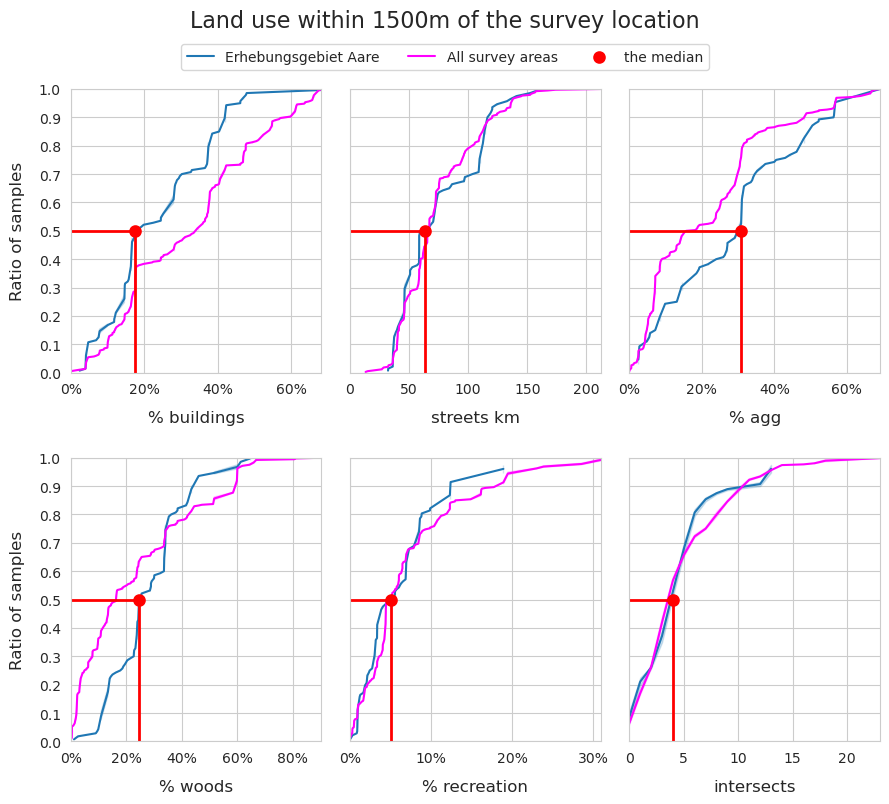

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(9,8), sharey="row")
from matplotlib.ticker import MultipleLocator
for i, n in enumerate(land_use_columns):
    r = i%2
    c = i%3
    ax=axs[r,c]
    
    # the value of landuse feature n for the survey area:
    data=feature_profile[n].values
    xs, ys = empiricalCDF(data)   
    sns.lineplot(x=xs, y=ys, ax=ax, label=summary_data.label)
    
    # the value of the land use feature n for all the data
    testx, testy = empiricalCDF(project_profile[n].values)
    sns.lineplot(x=testx, y=testy, ax=ax, label="All survey areas", color="magenta")
    
    # get the median from the data
    the_median = np.median(data)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=2)
    
    if i <= 3:
        if c == 0:            
            ax.set_ylabel("Ratio of samples", **ck.xlab_k)
            ax.yaxis.set_major_locator(MultipleLocator(.1))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass      
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()    
    ax.set_xlabel(n, **ck.xlab_k)
    ax.margins(x=0, y=0)
    
plt.tight_layout()
plt.subplots_adjust(top=.9, hspace=.3)
plt.suptitle("Land use within 1500m of the survey location", ha="center", y=1, fontsize=16)
fig.legend(handles, labels, bbox_to_anchor=(.5,.94), loc="center", ncol=3)    

plt.show()

### Kumulative Gesamtmengen nach Gewässer

In [9]:
# aggregate the dimensional data

agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

dims_parameters = dict(this_level=this_level, 
                       locations=fd.location.unique(), 
                       start_end=start_end, 
                       agg_dims=agg_dims)

dims_table = sut.gather_dimensional_data(dfDims, **dims_parameters)

# map the qauntity to the dimensional data
q_map = fd.groupby(this_level).quantity.sum()

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, "samples"] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, "quantity"] = q_map[name]

In [10]:


    
# map water_name_slug to water_name
wname_wname = dfBeaches[["water_name_slug","water_name"]].reset_index(drop=True).drop_duplicates().set_index("water_name_slug")
comp_labels = {x:wname_wname.loc[x][0] for x in fd[this_level].unique()}
# add proper names for display
dims_table["water_feature"] = dims_table.index.map(lambda x: comp_labels[x])
dims_table.set_index("water_feature", inplace=True)
   
# get the sum of all survey areas
dims_table.loc[this_feature["name"]]= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={"samples":"samples","quantity":"items", "total_w":"total kg", "mac_plast_w":"plastic kg", "area":"m²", "length":"meters"}, inplace=True)

# format kilos and text strings
dims_table["plastic kg"] = dims_table["plastic kg"]/1000
dims_table[["m²", "meters", "samples", "items"]] = dims_table[["m²", "meters", "samples", "items"]].applymap(lambda x: "{:,}".format(int(x)))
dims_table[["plastic kg", "total kg"]] = dims_table[["plastic kg", "total kg"]].applymap(lambda x: "{:.2f}".format(x))

# figure caption
agg_caption = F"""
*__Unten:__ Die kumulierten Gewichte und Merkmale für das Erhebungsgebiet Aare nach Gewässern.*
"""
md(agg_caption)


*__Unten:__ Die kumulierten Gewichte und Merkmale für das Erhebungsgebiet Aare nach Gewässern.*


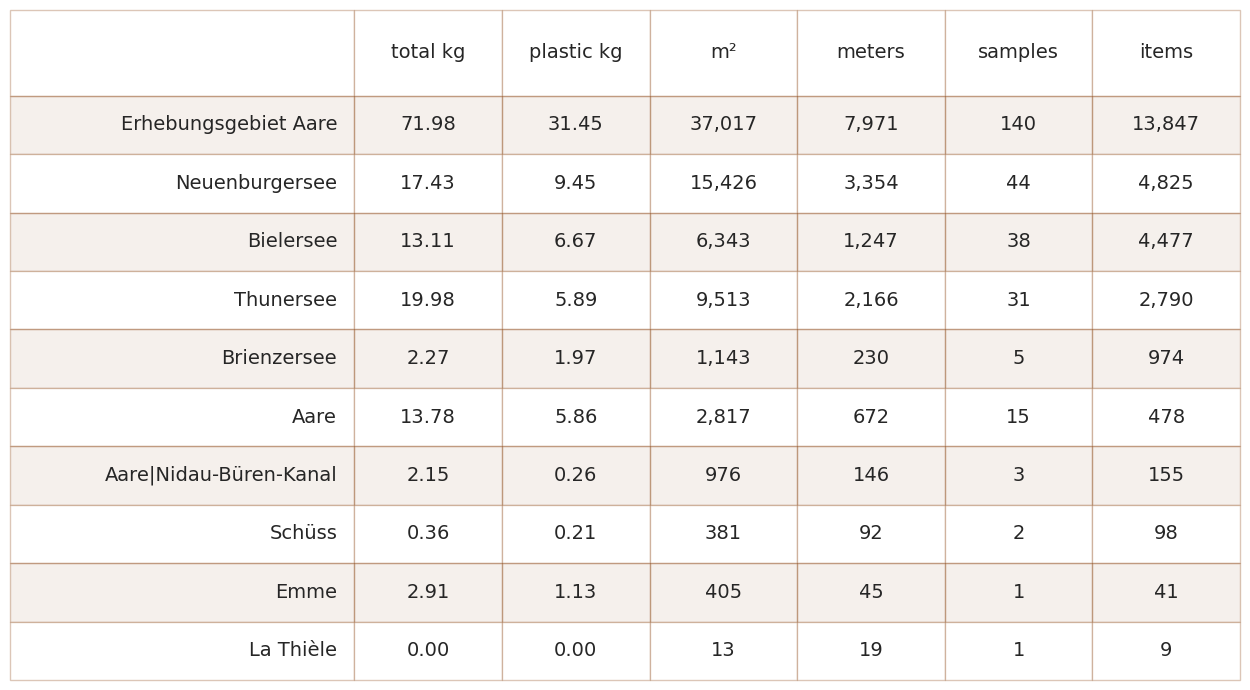

In [11]:
# make table
data = dims_table.reset_index()
colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*1.8,len(data)*.7))
sut.hide_spines_ticks_grids(ax)

table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, colWidths=[.28, *[.12]*6], a_color=table_row)
table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.show()

### Verteilung der Erhebungsergebnisse

In [12]:
# the surveys to chart
# common aggregations: sum the pcs/m and quantity per event and location
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}

# daily survey totals
dt_all = fd.groupby(["loc_date","location",this_level, "city","date"], as_index=False).agg(agg_pcs_quantity)
fd_dindex = dt_all.copy()

# Daily totals from all other locations
ots = dict(level_to_exclude=this_feature["level"], components_to_exclude=fd[this_feature["level"]].unique())
dts_date = sut.the_other_surveys(a_data, **ots)
dts_date = dts_date.groupby(["loc_date","date"], as_index=False)[unit_label].sum()
dts_date["date"] = pd.to_datetime(dts_date["date"]).dt.tz_localize('UTC')   

# scale the chart as needed to accomodate for extreme values
y_lim = 95
y_limit = np.percentile(dts_date[unit_label], y_lim)

# label for the chart that alerts to the scale
# not_included = F"Values greater than {round(y_limit, 1)} not shown."
not_included = F"Werte grösser als {locale.format_string('%d', round(y_limit, 1), grouping=True)} {unit_label} werden nicht gezeigt."

# figure caption
# chart_notes = F"""
# *__Left:__ {this_feature["name"]}, {start_date[:7]} through {end_date[:7]}, n={t["loc_date"]}. {not_included} __Right:__ {this_feature["name"]} empirical cumulative distribution of survey results.*
# """
chart_notes = f"""
*__Links:__ {this_feature["name"]}, {start_date[3:]} bis {end_date[3:]}, n={t["loc_date"]}. {not_included} __Rechts:__ empirische Verteilungsfunktion im {this_feature["name"]}.*
"""
md(chart_notes )

NameError: name 't' is not defined

In [ ]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

# get the monthly or quarterly results for the feature
rsmp = fd_dindex.set_index("date")
resample_plot, rate = sut.quarterly_or_monthly_values(rsmp, this_feature["name"], vals=unit_label, quarterly=["ticino"])

# chart label for top level aggregation
# top = "All survey areas"

fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(data=dts_date, x=dts_date["date"], y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)
# all other surveys
sns.scatterplot(data=fd_dindex, x=fd_dindex["date"], y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)

# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: {rate} median", color="magenta", ax=ax)

ax.set_ylim(0,y_limit )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = ECDF(dt_all[unit_label].values)    
sns.lineplot(x=feature_ecd.x, y=feature_ecd.y, color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = ECDF(dts_date[unit_label].values)
sns.lineplot(x=other_features.x, y=other_features.y, color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Ratio of samples", **ck.xlab_k14)

plt.tight_layout()
plt.show()

### Zusammengefasste Daten und Materialarten

In [ ]:
# figure caption
# summary_of_survey_totals = F"""
# *__Left:__ {this_feature["name"]} summary of survey totals. __Right:__ {this_feature["name"]} material type and percent of total.*
# """
summary_of_survey_totals = f"""
*__Links:__ Zusammenfassung der Daten aller Erhebungen {this_feature["name"]}. __Rechts:__ Gefundene Materialarten im {this_feature["name"]} n Stückzahlen und als prozentuale Anteile (stückzahlbezogen).*
"""
md(summary_of_survey_totals)

In [ ]:
# get the basic statistics from pd.describe
cs = dt_all[unit_label].describe().round(2)

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

# make a map to the code descriptions
code_description_map = dfCodes.description
# make a map to the code materials
code_material_map = dfCodes.material
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(
    fd,
    agg=agg_pcs_median,
    description_map=code_description_map, 
    material_map=code_material_map
)

# the materials table
fd_mat_totals = sut.the_ratio_object_to_total(code_totals)
fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)
fd_mat_totals = sut.make_string_format(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [this_feature["name"], "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(14)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## Die am häufigsten gefundenen Objekte

Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden (Häufigkeitsrate)

In [ ]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] >= a_fail_rate].sort_values(by="quantity", ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# figure caption
# rb_string = F"""
# *__Below:__ {this_feature['name']} most common objects: fail rate >/= {a_fail_rate}%  and/or top ten by quantity. Combined, the most abundant objects represent {int(m_common_percent_of_total*100)}% of all objects found.*

# Note : {unit_label} = median survey value.
# """

rb_string = f"""
*__Unten__: Häufigste Objekte im {this_feature['name']}: d. h. Objekte mit einer Häufigkeitsrate von mindestens 50 % und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte {int(m_common_percent_of_total*100)}% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.*
"""
md(rb_string)

In [ ]:
# format values for table
m_common["item"] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x: "{:,}".format(x))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{round(x,1)}")

cols_to_use = {"item":"Item","quantity":"Quantity", "% of total":"% of total", "fail rate":"Fail rate", unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(14)
plt.tight_layout()
plt.show()

### Die am häufigsten gefundenen Objekte nach Gewässer

In [ ]:
rb_string = F"""
*__Unten:__ Median (p/100 m) der häufigsten Objekte im {this_feature["name"]}.*
"""
md(rb_string)

In [ ]:
# aggregated survey totals for the most common codes for all the water features
m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, "loc_date","code"], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, "code"], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft["f_name"] = m_common_ft[this_level].map(lambda x: comp_labels[x])

# map the desctiption to the code
m_common_ft["item"] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[["item", unit_label, "f_name"]].pivot(columns="f_name", index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the survey area
c = sut.aggregate_to_group_name(fd[fd.code.isin(m_common.index)], column="code", name=this_feature["name"], val="med")
m_c_p[this_feature["name"]]= sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# the aggregated totals of all the data
c = sut.aggregate_to_group_name(a_data[(a_data.code.isin(m_common.index))], column="code", name=top, val="med")
m_c_p[top] = sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# chart that
fig, ax  = plt.subplots(figsize=(len(m_c_p.columns)*.9,len(m_c_p)*.9))
axone = ax

sns.heatmap(m_c_p, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")
axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="x")
axone.tick_params(labelsize=12, which="both", axis="y")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()

### Die am häufigsten gefundenen Objekte im monatlichen Durchschnitt

In [ ]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*__Below:__ {this_feature["name"]}, monatliche Durchschnittsergebnisse p/100 m.*
"""
md(monthly_mc)

In [ ]:
months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(10,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=table_row, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(.5, -.05), loc="upper center",  ncol=2, fontsize=14)       
plt.show()

## Erhebungsergebnisse und Landnutzung

Das Landnutzungsprofil ist eine Darstellung der Art und des Umfangs der wirtschaftlichen Aktivität und der Umweltbedingungen rund um den Erhebungsort. Die Schlüsselindikatoren aus den Ergebnissen der Datenerhebungen werden mit dem Landnutzungsprofil für einen Radius von 1500 m um den Erhebungsort verglichen.
Eine Assoziation ist eine Beziehung zwischen den Ergebnissen der Datenerhebungen und dem Landnutzungsprofil, die nicht auf Zufall beruht. Das Ausmass der Beziehung ist weder definiert noch linear.
Die Rangkorrelation ist ein nicht-parametrischer Test, um festzustellen, ob ein statistisch signifikanter Zusammenhang zwischen der Landnutzung und den bei einer Abfallobjekte-Erhebung identifizierten Objekten besteht.
Die verwendete Methode ist der Spearmans Rho oder Spearmans geordneter Korrelationskoeffizient. Die Testergebnisse werden bei p < 0,05 für alle gültigen Erhebungen an Seen im Untersuchungsgebiet ausgewertet.
1. Rot/Rosa steht für eine positive Assoziation
2. Gelb steht für eine negative Assoziation
3. Weiss bedeutet, dass keine statistische Grundlage für die Annahme eines Zusammenhangs besteht

In [ ]:
corr_data = fd[(fd.code.isin(m_common.index))&(fd.water_name_slug.isin(lakes_of_interest))].copy()

alert_less_than_100 = len(corr_data.loc_date.unique()) <= 100

if alert_less_than_100:
    warning = F"""**There are less than 100 samples, proceed with caution. Beach litter surveys have alot of variance**"""
else:
    warning = ""

# association = F"""*__Below:__ {this_feature["name"]} ranked correlation of the most common objects with respect to land use profile.
# For all valid lake samples n={len(corr_data.loc_date.unique())}.*

# {warning}
# """

association = f"""

*__Unten:__ Ausgewertete Korrelationen der am häufigsten gefundenen Objekte in Bezug auf das Landnutzungsprofil im {this_feature["name"]}. Für alle gültigen Erhebungen an Seen n = {len(corr_data.loc_date.unique())}.*

{warning}
"""


md(association)

In [ ]:
# chart the results of test for association
fig, axs = plt.subplots(len(m_common.index),len(land_use_columns), figsize=(len(land_use_columns)+7,len(m_common.index)+1), sharey="row")

# the test is conducted on the survey results for each code
for i,code in enumerate(m_common.index):
    # slice the data
    data = corr_data[corr_data.code == code]
    
    # run the test on for each land use feature
    for j, n in enumerate(land_use_columns):       
        # assign ax and set some parameters
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis="both", which="both",bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
        
        # check the axis and set titles and labels       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha="right", **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        # run test
        _, corr, a_p = sut.make_plot_with_spearmans(data, ax, n)
        
        # if siginficant set adjust color to direction
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor("salmon")
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor("palegoldenrod")
                ax.patch.set_alpha(0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

*Legende: wenn p > 0,05 = weiss, wenn p < 0,05 und Rho > 0 = rot, wenn p < 0,05 und Rho < 0 = gelb *

## Verwendungszweck der gefundenen Objekte

Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

* Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden
* Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
* Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung
* Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
* Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.
* Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien
* Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.
* Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist
* Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung
* Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung
Im Anhang (Kapitel 3.6.3) befindet sich die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Das Kapitel [16 Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe.

In [ ]:
cg_poft = F"""
__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gewässer im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.
"""
md(cg_poft)

In [ ]:
# code groups resluts aggregated by survey
groups = ["loc_date","groupname"]
cg_t = fd.groupby([this_level,*groups], as_index=False).agg(agg_pcs_quantity)

# the total per water feature
cg_tq = cg_t.groupby(this_level).quantity.sum()

# get the fail rates for each group per survey
cg_t["fail"]=False
cg_t["fail"] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each municipality
agg_this = {unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"} 
cg_t = cg_t.groupby([this_level, "groupname"], as_index=False).agg(agg_this)

# assign survey area total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, "f_total"] = cg_tq.loc[a_feature]

# get the percent of total for each group for each survey area
cg_t["pt"] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

# repeat for the survey area
data_table[bassin_label] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="pt")

# repeat for all the data
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="pt")

data = data_table
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.set_xlabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

In [ ]:
cg_medpcm = F"""
<br></br>
*__Below:__ Verwendungszweck der gefundenen Objekte Median p/100 m im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*
"""
md(cg_medpcm)

In [ ]:
# median p/50m of all the water features
data_table = cg_t.pivot(columns="water_name_slug", index="groupname", values=unit_label)

# the survey area columns
data_table[bassin_label] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="med")

# column for all the surveys
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="med")

# merge with data_table
data = data_table
data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Fliessgewässer

In [ ]:
rivers = fd[fd.w_t == "r"].copy()
r_smps = rivers.groupby(["loc_date", "date", "location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)
l_smps = fd[fd.w_t == "l"].groupby(["loc_date","date","location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)

chart_notes = F"""
*__Left:__ {this_feature["name"]} Fliessgewässer, {start_date[:7]} bis {end_date[:7]}, n = {len(r_smps.loc_date.unique())}. {not_included} __Rechts:__ Zusammenfassung der Daten.*
"""
md(chart_notes )

In [ ]:
cs = r_smps[unit_label].describe().round(2)

# add project totals
cs["total objects"] = r_smps.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

# make the charts
fig = plt.figure(figsize=(11,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top}"

sns.scatterplot(data=l_smps, x="date", y=unit_label, color="black", alpha=0.4, label="Lake surveys", ax=ax)
sns.scatterplot(data=r_smps, x="date", y=unit_label, color="red", s=34, ec="white",label="River surveys", ax=ax)

ax.set_ylim(-10,y_limit )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

a_col = [this_feature["name"], "total"]

axone = fig.add_subplot(aspec[:, 7:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")


plt.show()

### Die an Fliessgewässern am häufigsten gefundenen Objekte

In [ ]:
riv_mcommon = F"""
*__Below:__ Häufigste Objekte p/100 m an Fliessgewässern im {this_feature["name"]}: Medianwert der Erhebung.*
"""
md(riv_mcommon)

In [ ]:
# the most common items rivers
r_codes = rivers.groupby("code").agg({"quantity":"sum", "fail":"sum", unit_label:"median"})
r_codes["Fail rate"] = (r_codes.fail/r_smps.loc_date.nunique()*100).astype("int")

# top ten
r_byq = r_codes.sort_values(by="quantity", ascending=False)[:10].index

# most common
r_byfail = r_codes[r_codes["Fail rate"] > 49.99].index
r_most_common = list(set(r_byq) | set(r_byfail))

# format for display
r_mc= r_codes.loc[r_most_common].copy()
r_mc["item"] = r_mc.index.map(lambda x: code_description_map.loc[x])
r_mc.sort_values(by="quantity", ascending=False, inplace=True)

r_mc["% of total"]=((r_mc.quantity/r_codes.quantity.sum())*100).astype("int")
r_mc["% of total"] = r_mc["% of total"].map(lambda x: F"{x}%")
r_mc["quantity"] = r_mc.quantity.map(lambda x: "{:,}".format(x))
r_mc["Fail rate"] = r_mc["Fail rate"].map(lambda x: F"{x}%")
r_mc["p/50m"] = r_mc[unit_label].map(lambda x: F"{np.ceil(x)}")
r_mc.rename(columns=cols_to_use, inplace=True)

data=r_mc[["Item","Quantity", "% of total", "Fail rate", unit_label]]

fig, axs = plt.subplots(figsize=(11,len(data)*.8))

sut.hide_spines_ticks_grids(axs)

table_six = sut.make_a_table(axs, data.values,  colLabels=list(data.columns), colWidths=[.48, .13,.13,.13, .13], **{"loc":"lower center"})
table_six.get_celld()[(0,0)].get_text().set_text(" ")


plt.show()
plt.tight_layout()
plt.close()

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse

Die folgende Tabelle enthält die Komponenten«»Gfoa»» und«»Gfrag»», die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert.

In [ ]:
frag_foams = F"""
*__Below:__ Fragmentierte und geschäumte Kunststoffe nach Grösse im {this_feature["name"]},  Median p/100 m, Anzahl der gefundenen Objekte und Prozent der Gesamtmenge.*
"""
md(frag_foams)

In [ ]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
some_foams = ["G81", "G82", "G83", "G74"]

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(t["locations"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.4,len(data)*.7))

sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs,data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], a_color=table_row)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")
table_seven.set_fontsize(14)

plt.show()
plt.tight_layout()
plt.close()

### Die Erhebungsorte

In [ ]:
# display the survey locations
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[t["locations"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"slug":"location"}, inplace=True)
disp_beaches.set_index("location", inplace=True, drop=True)

disp_beaches

### Inventar der Objekte

In [ ]:
pd.set_option("display.max_rows", None)
complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity", "% of total","fail rate"]]
complete_inventory.sort_values(by="quantity", ascending=False)